## Run and Rise Over Trend Feats

In [46]:
import pandas as pd
from tqdm.notebook import tqdm  # Use notebook version of tqdm for better compatibility with Jupyter
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.patches as patches
from pandas.tseries.offsets import DateOffset
import plotly.graph_objects as go
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [47]:
plt.style.use('default')

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the price data

In [49]:
# db_path = '../raw/daily-2020.csv'
db_path = '/content/drive/MyDrive/daily-2020.csv'
price_df = pd.read_csv(db_path, usecols=["timestamp", "close", "open", "high", "low", "volume"])
price_df.set_index('timestamp', inplace=True)
price_df.index = pd.to_datetime(price_df.index, unit='s')

### Volatility calculation and event extraction

In [50]:
def get_daily_vol(close, span0=100):
    """
    Calculate the daily volatility of closing prices.

    Parameters:
    - close: A pandas Series of closing prices.
    - span0: The span for the EWM standard deviation.

    Returns:
    - A pandas Series of daily volatility estimates.
    """
    # Find the start of the previous day for each day
    prev_day_start = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    prev_day_start = prev_day_start[prev_day_start > 0]

    # Create a series with the start of the previous day for each day
    prev_day_start = pd.Series(close.index[prev_day_start - 1], index=close.index[close.shape[0] - prev_day_start.shape[0]:])

    # Calculate daily returns
    daily_returns = close.loc[prev_day_start.index] / close.loc[prev_day_start.values].values - 1

    # Calculate EWM standard deviation of daily returns
    daily_vol = daily_returns.ewm(span=span0).std()

    return daily_returns, daily_vol

In [51]:
price_df["daily_returns"], price_df["volatility"] = get_daily_vol(price_df.close)

In [52]:
price_df.dropna(inplace=True)

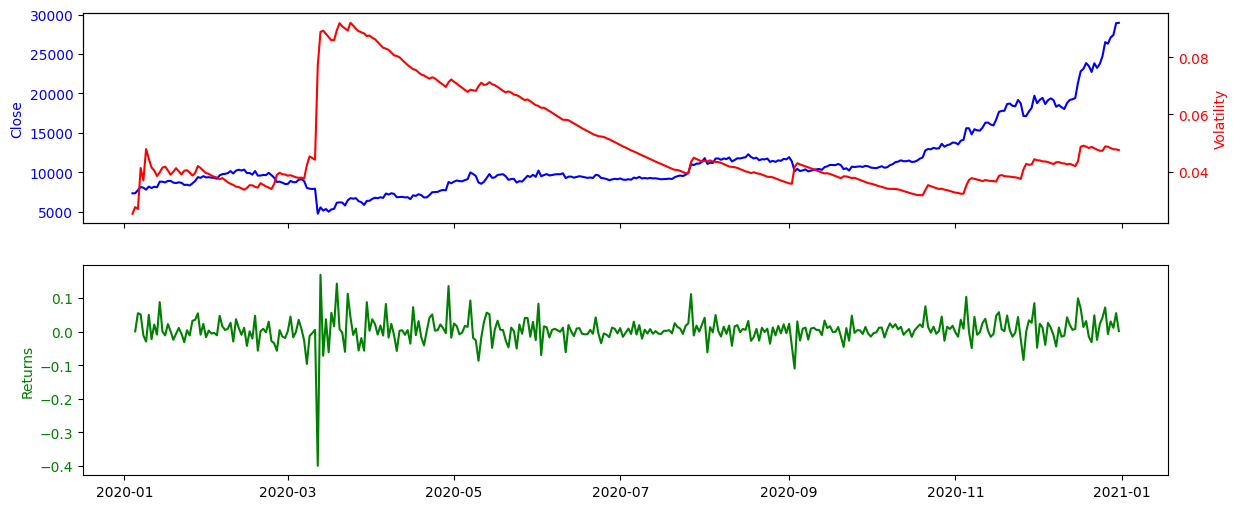

In [53]:
# Calculate returns
price_df['returns'] = price_df['close'].pct_change()

# Create a new figure with two subplots
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(14, 6))

# Plot 'close' on the primary y-axis of the first subplot
ax1.plot(price_df.index, price_df['close'], color='blue')
ax1.set_ylabel('Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for 'volatility' on the first subplot
ax2 = ax1.twinx()
ax2.plot(price_df.index, price_df['volatility'], color='red')
ax2.set_ylabel('Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot 'returns' on the second subplot
ax3.plot(price_df.index, price_df['returns'], color='green')
ax3.set_ylabel('Returns', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Show the plot
plt.show()

In [54]:
def get_t_events(raw_price, volatility, base_threshold):
    """
    :param raw_price: (series) of close prices.
    :param volatility: (series) of volatility values.
    :param base_threshold: (float) base level for the threshold.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events, s_pos, s_neg = [], 0, 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        # Adjust the threshold based on volatility
        threshold = base_threshold * volatility.loc[i]

        s_pos = max(0.0, float(s_pos + diff.loc[i]))
        s_neg = min(0.0, float(s_neg + diff.loc[i]))

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

In [55]:
events = get_t_events(price_df.close, price_df.volatility, 1.5)

Applying Symmetric CUSUM filter.


  0%|          | 0/361 [00:00<?, ?it/s]

In [56]:
price_df["event"] = price_df.index.isin(events)

In [57]:
price_df

,open,high,low,close,volume,daily_returns,volatility,returns,event
timestamp,,,,,,,,,
2020-01-04,7341.60,7400.00,7269.21,7350.71,92586.033,0.055827,0.025314,NaN,False
2020-01-05,7350.54,7495.00,7303.00,7354.36,117765.972,0.001722,0.027620,0.000497,False
2020-01-06,7354.36,7808.65,7345.00,7757.39,168150.317,0.055325,0.026958,0.054802,True
2020-01-07,7757.74,8215.33,7733.00,8152.49,280809.162,0.108525,0.041275,0.050932,False
2020-01-08,8150.90,8468.42,7870.11,8059.84,321225.114,0.038989,0.036967,-0.011365,False
...,...,...,...,...,...,...,...,...,...
2020-12-27,26508.84,28459.84,25850.00,26305.64,540264.148,0.063714,0.048716,-0.007665,False
2020-12-28,26301.76,27538.82,26117.10,27102.66,267563.468,0.022401,0.048231,0.030298,True
2020-12-29,27101.45,27441.73,25913.01,27402.83,260759.449,0.041709,0.047837,0.011075,False


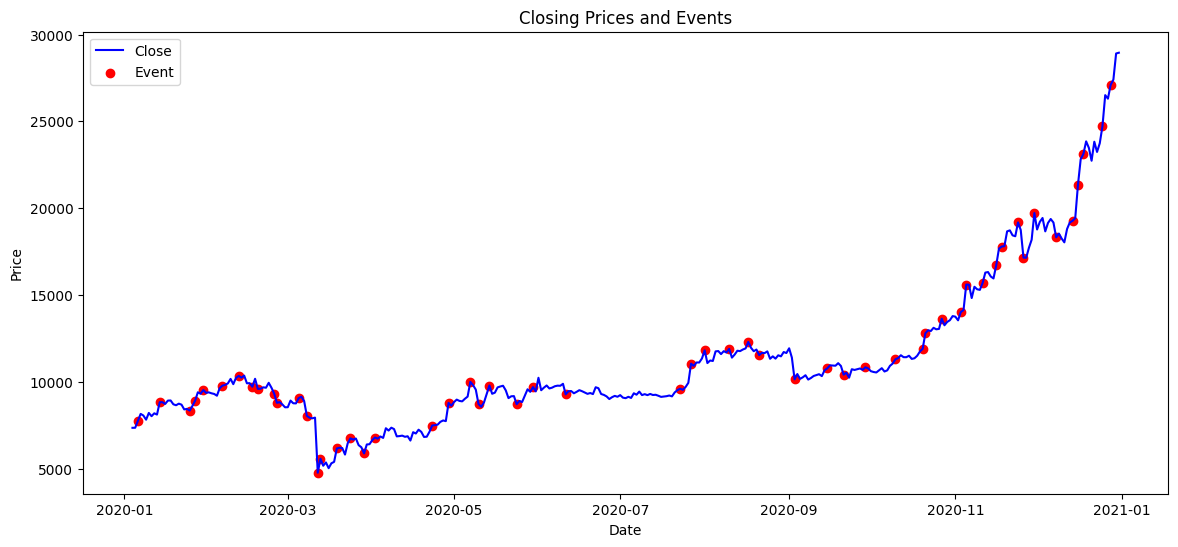

In [58]:
# Plot the closing prices
plt.subplots(figsize=(14, 6))
plt.plot(price_df.index, price_df['close'], color='blue', label='Close')

# Add dots for the event dates
plt.scatter(events, price_df.loc[events, 'close'], color='red', label='Event')

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing Prices and Events')
plt.legend()

# Show the plot
plt.show()

### Triple Barrier Labeling

In [59]:
# Define labels as named constants for readability
LABEL_UP = 1
LABEL_DOWN = -1
LABEL_NEUTRAL = 0

In [60]:
def calculate_barriers(df, i, window, upper_barrier_factor, lower_barrier_factor, volatility_period, barrier_type='volatility'):
    end_window = min(i+window, len(df)-1)  # Ensure the window does not exceed the dataframe

    # Calculate the mean volatility or daily returns over the volatility_period
    if barrier_type == 'volatility':
        mean_value = df.loc[i-volatility_period+1:i, 'volatility'].mean()
        current_value = df.loc[i, 'volatility']
    elif barrier_type == 'returns':
        mean_value = df.loc[i-volatility_period+1:i, 'daily_returns'].mean()
        current_value = df.loc[i, 'daily_returns']
    else:
        print(f'the barrier type: {barrier_type}')
        raise ValueError("Invalid barrier_type. Choose either 'volatility' or 'returns'")

    df.loc[i:end_window, 'upper_barrier'] = df.loc[i, 'close'] + (df.loc[i, 'close'] * current_value * upper_barrier_factor)
    df.loc[i:end_window, 'lower_barrier'] = df.loc[i, 'close'] - (df.loc[i, 'close'] * current_value * lower_barrier_factor)
    return df

In [61]:
def label_observations(df, origin, i, label):
    df.loc[origin:i+1, 'labels'] = label
    return df

In [62]:
def triple_barrier_labeling(sdf, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility', touch_type="HL"):
    df = sdf.copy()
    df = df.reset_index()

    # Initialize labels and window start
    df['labels'] = LABEL_NEUTRAL
    df['window_start'] = False

    window = vertical_barrier
    origin = 0
    touch_upper = lambda high, barrier: high >= barrier
    touch_lower = lambda low, barrier: low <= barrier
    # For each observation
    for i in range(0, len(df)):
        # Define your barriers at the beginning of each window
        if i == origin:
            df = calculate_barriers(df, i, window, upper_barrier_factor, lower_barrier_factor, volatility_period, barrier_type)
            df.loc[i, 'window_start'] = True  # Mark the start of the window

        # one of the conditions were met
        if touch_upper(df.loc[i, "high" if touch_type == 'HL' else 'close'], df.loc[i, "upper_barrier"]):
            if (i - origin > min_trend_days):
                # label the observations
                df = label_observations(df, origin, i, LABEL_UP)
                # set new origin
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index
                # reset window
                window = vertical_barrier
        elif touch_lower(df.loc[i, "low" if touch_type == 'HL' else 'close'], df.loc[i, "lower_barrier"]):
            if (i - origin > min_trend_days):
                # label the observations
                df = label_observations(df, origin, i, LABEL_DOWN)
                # set new origin
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index
                # reset window
                window = vertical_barrier

        # none of the conditions were met
        else:
            if window > 0:
                # reduce window size by one
                window = window - 1
            else:
                # reset window
                window = vertical_barrier
                # label neutral from origin to origin + window
                df.loc[origin:min(origin+window, len(df)-1), 'labels'] = LABEL_NEUTRAL  # Ensure the window does not exceed the dataframe
                # set origin to the next id
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index

    df = df.set_index("timestamp")
    return df

In [63]:
tbl_df = triple_barrier_labeling(price_df, volatility_period=8, upper_barrier_factor=1.0, lower_barrier_factor=1.1, vertical_barrier=5, min_trend_days=2, barrier_type='volatility')

In [64]:
tbl_df.labels.value_counts()

,count
labels,
1,158
0,129
-1,76


In [65]:
def plot_triple_barrier(df,loc=1,sample_point_index=10, start_index = 0, n_days = 100 ,time_out = 20 ):
  """
    parameters :
      loc = 1 => position of smaller plot up
      loc = 2 => position of smaller plot down
      sample_point_index : the point which is going to show the labelling details
      time_out : how many next day's data are used for labeling of each point
  """
  price = df.close.to_numpy()[start_index:start_index+n_days]
  # Set initial barriers
  profit_taking = 1.0  # Multiplier for the volatility adjustment
  stop_loss = 1.0  # Multiplier for the volatility adjustment

  # Calculate rolling volatility (standard deviation)
  window = 10  # Window size for rolling calculation
  rolling_volatility = pd.Series(price).rolling(window=window).std().fillna(0)

  # Initialize arrays to hold the barrier values
  upper_barrier = np.zeros(n_days)
  lower_barrier = np.zeros(n_days)

  # Initialize arrays to hold labels
  high_points = np.zeros(n_days, dtype=bool)
  low_points = np.zeros(n_days, dtype=bool)
  neutral_points = np.zeros(n_days, dtype=bool)

  # Iterate over each day to calculate barriers and labels
  for i in range(n_days):
      if i + time_out < n_days:
          future_prices = price[i:i + time_out]
          upper_barrier[i] = price[i] + (profit_taking * rolling_volatility[i])
          lower_barrier[i] = price[i] - (stop_loss * rolling_volatility[i])

          # Check if any future price crosses the barriers
          if np.any(future_prices >= upper_barrier[i]):
              high_points[i] = True
          elif np.any(future_prices <= lower_barrier[i]):
              low_points[i] = True
          else:
              neutral_points[i] = True
      else:
          upper_barrier[i] = np.nan
          lower_barrier[i] = np.nan
          neutral_points[i] = True

  # Plot the stock prices and barriers
  fig, ax = plt.subplots(figsize=(14, 7))
  ax.plot(price, label='Stock Price', color='blue')
  ax.plot(upper_barrier, color='green', linestyle='--', label='Profit Taking Barrier (Volatility Adjusted)')
  ax.plot(lower_barrier, color='red', linestyle='--', label='Stop Loss Barrier (Volatility Adjusted)')
  ax.axvline(time_out, color='purple', linestyle='--', label='Time Out Barrier')

  # Highlight high, low, and neutral points
  ax.scatter(np.where(high_points)[0], price[high_points], color='green', marker='^', label='High Points')
  ax.scatter(np.where(low_points)[0], price[low_points], color='red', marker='v', label='Low Points')
  ax.scatter(np.where(neutral_points)[0], price[neutral_points], color='orange', marker='o', label='Neutral Points')

  # Adding labels and title
  ax.set_xlabel('Days')
  ax.set_ylabel('Price')
  ax.set_title('Stock Prices with Volatility-Adjusted Triple Barrier and Points Classification')
  ax.legend()
  ax.grid(True)



  if sample_point_index is not np.nan:
      if loc == 1:
        inset_ax = inset_axes(ax, width="25%", height="25%", loc=9)
      else:
        inset_ax = inset_axes(ax, width="25%", height="25%", loc=8)

      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), price[sample_point_index:sample_point_index + time_out], label='Stock Price', color='blue')
      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), np.full(time_out, upper_barrier[sample_point_index]), color='green', linestyle='--', label='Upper Barrier')
      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), np.full(time_out, lower_barrier[sample_point_index]), color='red', linestyle='--', label='Lower Barrier')
      inset_ax.grid(True)

      if loc == 1 :
        pos = (0.5, 0.9)
      else :
        pos = (0.3, 0.3)

      ax.annotate('',
                  xy=(sample_point_index, price[sample_point_index]),
                  xycoords='data',
                  xytext=pos,
                  textcoords='axes fraction',
                  arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
                  horizontalalignment='right', verticalalignment='bottom')

  plt.show()

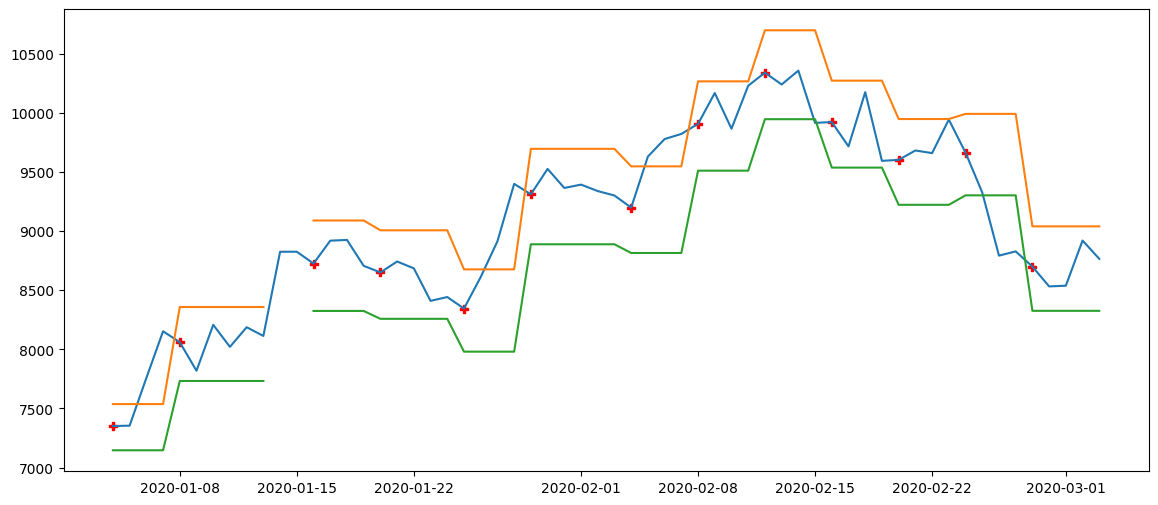

In [66]:
plot_df = tbl_df[0:60]
# Create a new DataFrame where 'window_start' is True
window_starts = plot_df[plot_df['window_start']]

plt.subplots(figsize=(14, 6))

# Plot the 'close', 'upper_barrier', and 'lower_barrier' columns
plt.plot(plot_df.index, plot_df[['close', 'upper_barrier', 'lower_barrier']], ms=1)

# Add markers at the start of each window
plt.scatter(window_starts.index, window_starts['close'], color='red', marker="P")

plt.show()

In [67]:
def band_generator(labels):
    bands = [{'label': labels.iloc[0], 'from': labels.index[0]}]
    for l, i in enumerate(labels):
        if i == bands[-1]["label"]:
            pass
        else:
            bands[-1]["to"] = labels.index[l]
            # Check if l + 1 is within the range of the labels' indices
            if l + 1 < len(labels):
                bands.append({'label': i, 'from': labels.index[l + 1]})

    # Check if the last band has a 'to' field
    if 'to' not in bands[-1]:
        bands[-1]['to'] = labels.index[-1]

    return bands

In [68]:
def plot_labels(price_series, labels):
    """
    Plot price series with bullish and bearish areas.

    Parameters:
    - price_series: A pandas Series of prices.
    - labels: A pandas Series of labels (-1, 0, 1).
    """
    # Create a new figure
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()

    # Plot the price series
    ax1.plot(price_series.index, price_series.values, label='Price', color='blue')

    # Draw a box for each window
    for label in labels:
        # Shift "from" and "to" by half a day
        from_timestamp = label["from"] - DateOffset(hours=12)
        to_timestamp = label["to"] + DateOffset(hours=12)

        # Ensure the timestamps are within the price series index
        from_timestamp = max(from_timestamp, price_series.index[0])
        to_timestamp = min(to_timestamp, price_series.index[-1])

        # Add the band
        ax2.fill_betweenx(ax1.get_ylim(), from_timestamp, to_timestamp, color='green' if label["label"] == 1 else "red" if label["label"] == -1 else 'white' , alpha=0.3)

    # Add a legend
    ax1.legend()

    # Show the plot
    plt.show()

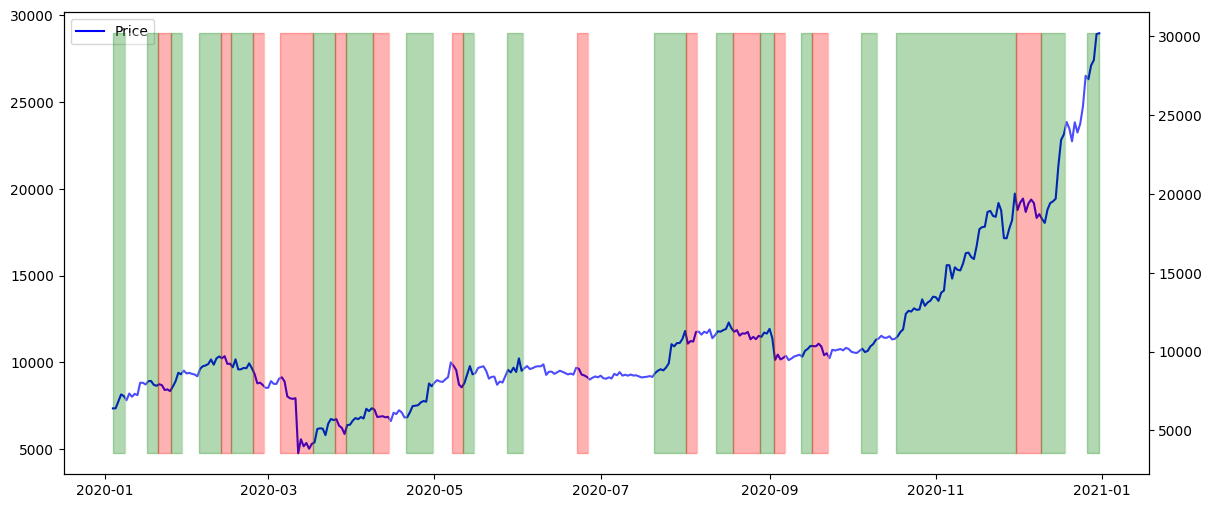

In [69]:
prices = tbl_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)

In [70]:
price_df

,open,high,low,close,volume,daily_returns,volatility,returns,event
timestamp,,,,,,,,,
2020-01-04,7341.60,7400.00,7269.21,7350.71,92586.033,0.055827,0.025314,NaN,False
2020-01-05,7350.54,7495.00,7303.00,7354.36,117765.972,0.001722,0.027620,0.000497,False
2020-01-06,7354.36,7808.65,7345.00,7757.39,168150.317,0.055325,0.026958,0.054802,True
2020-01-07,7757.74,8215.33,7733.00,8152.49,280809.162,0.108525,0.041275,0.050932,False
2020-01-08,8150.90,8468.42,7870.11,8059.84,321225.114,0.038989,0.036967,-0.011365,False
...,...,...,...,...,...,...,...,...,...
2020-12-27,26508.84,28459.84,25850.00,26305.64,540264.148,0.063714,0.048716,-0.007665,False
2020-12-28,26301.76,27538.82,26117.10,27102.66,267563.468,0.022401,0.048231,0.030298,True
2020-12-29,27101.45,27441.73,25913.01,27402.83,260759.449,0.041709,0.047837,0.011075,False


In [71]:
prices

,open,high,low,close,volume,daily_returns,volatility,returns,event,labels,window_start,upper_barrier,lower_barrier
timestamp,,,,,,,,,,,,,
2020-01-04,7341.60,7400.00,7269.21,7350.71,92586.033,0.055827,0.025314,NaN,False,1,True,7536.786044,7146.026351
2020-01-05,7350.54,7495.00,7303.00,7354.36,117765.972,0.001722,0.027620,0.000497,False,1,False,7536.786044,7146.026351
2020-01-06,7354.36,7808.65,7345.00,7757.39,168150.317,0.055325,0.026958,0.054802,True,1,False,7536.786044,7146.026351
2020-01-07,7757.74,8215.33,7733.00,8152.49,280809.162,0.108525,0.041275,0.050932,False,1,False,7536.786044,7146.026351
2020-01-08,8150.90,8468.42,7870.11,8059.84,321225.114,0.038989,0.036967,-0.011365,False,0,True,8357.785498,7732.099952
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,26508.84,28459.84,25850.00,26305.64,540264.148,0.063714,0.048716,-0.007665,False,1,False,27803.000420,25085.242538
2020-12-28,26301.76,27538.82,26117.10,27102.66,267563.468,0.022401,0.048231,0.030298,True,1,False,27803.000420,25085.242538
2020-12-29,27101.45,27441.73,25913.01,27402.83,260759.449,0.041709,0.047837,0.011075,False,1,False,27803.000420,25085.242538


In [72]:
# Calculate average duration of trends
def calculate_average_duration(df):
    current_label = df['labels'].iloc[0]
    duration_sum = 0
    trend_count = 0
    trend_start = df.index[0]
    for i in range(1, len(df)):
        if df['labels'].iloc[i] != current_label:
            duration_sum += (df.index[i] - trend_start).days
            trend_count += 1
            trend_start = df.index[i]
            current_label = df['labels'].iloc[i]
    average_duration = duration_sum / trend_count if trend_count > 0 else 0
    return average_duration

In [73]:
average_duration = calculate_average_duration(prices)
average_duration

8.30232558139535

In [74]:
def run_over_trend(df, avg_duration):
    df['run_over_trend'] = 0.0
    window_size = pd.Timedelta(days=avg_duration)

    # Iterate through the dataset in windows of `avg_duration`
    start_date = df.index[0]
    while start_date <= df.index[-1]:
        end_date = start_date + window_size

        # Extract the current window
        window = df[start_date:end_date]
        trend_length = (window.index[-1] - window.index[0]).days

        for i, date in enumerate(window.index):
            run_position = (date - window.index[0]).days + 1
            df.loc[date, 'run_over_trend'] = run_position / trend_length

        # Move to the next window
        start_date = end_date

    return df


In [75]:
def rise_over_trend(df, avg_duration):
    # Calculate average percentage change across all trend windows
    trend_changes = []
    window_size = pd.Timedelta(days=avg_duration)

    start_date = df.index[0]
    while start_date <= df.index[-1]:
        end_date = start_date + window_size
        window = df[start_date:end_date]

        if len(window) < 2:
            start_date = end_date
            continue

        start_price = window['close'].iloc[0]
        end_price = window['close'].iloc[-1]
        percentage_change = ((end_price - start_price) / start_price) * 100
        trend_changes.append(percentage_change)

        start_date = end_date

    average_change = sum(trend_changes) / len(trend_changes) if trend_changes else 0

    # Calculate rise_over_trend for each data point
    df['rise_over_trend'] = 0.0
    start_date = df.index[0]

    while start_date <= df.index[-1]:
        end_date = start_date + window_size
        window = df[start_date:end_date]

        if len(window) < 2:
            start_date = end_date
            continue

        start_price = window['close'].iloc[0]
        for date in window.index:
            current_price = window.loc[date, 'close']
            percentage_change = ((current_price - start_price) / start_price) * 100
            df.loc[date, 'rise_over_trend'] = percentage_change / average_change if average_change != 0 else 0

        start_date = end_date

    return df


In [76]:
def previous_window_trend(df, avg_duration):
    df['previous_window_trend'] = 0
    window_size = pd.Timedelta(days=avg_duration)
    previous_label = None

    start_date = df.index[0]

    while start_date <= df.index[-1]:
        end_date = start_date + window_size
        window = df[start_date:end_date]

        if previous_label is not None:
            df.loc[start_date:end_date, 'previous_window_trend'] = previous_label

        if not window.empty:
            previous_label = window['labels'].iloc[-1]

        start_date = end_date

    return df


In [77]:
test_prices = run_over_trend(prices, average_duration)
test_prices

,open,high,low,close,volume,daily_returns,volatility,returns,event,labels,window_start,upper_barrier,lower_barrier,run_over_trend
timestamp,,,,,,,,,,,,,,
2020-01-04,7341.60,7400.00,7269.21,7350.71,92586.033,0.055827,0.025314,NaN,False,1,True,7536.786044,7146.026351,0.125
2020-01-05,7350.54,7495.00,7303.00,7354.36,117765.972,0.001722,0.027620,0.000497,False,1,False,7536.786044,7146.026351,0.250
2020-01-06,7354.36,7808.65,7345.00,7757.39,168150.317,0.055325,0.026958,0.054802,True,1,False,7536.786044,7146.026351,0.375
2020-01-07,7757.74,8215.33,7733.00,8152.49,280809.162,0.108525,0.041275,0.050932,False,1,False,7536.786044,7146.026351,0.500
2020-01-08,8150.90,8468.42,7870.11,8059.84,321225.114,0.038989,0.036967,-0.011365,False,0,True,8357.785498,7732.099952,0.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,26508.84,28459.84,25850.00,26305.64,540264.148,0.063714,0.048716,-0.007665,False,1,False,27803.000420,25085.242538,0.400
2020-12-28,26301.76,27538.82,26117.10,27102.66,267563.468,0.022401,0.048231,0.030298,True,1,False,27803.000420,25085.242538,0.600
2020-12-29,27101.45,27441.73,25913.01,27402.83,260759.449,0.041709,0.047837,0.011075,False,1,False,27803.000420,25085.242538,0.800


In [78]:
average_duration = int(average_duration)
average_duration

8

In [79]:
test_prices = rise_over_trend(prices, average_duration)
test_prices

,open,high,low,close,volume,daily_returns,volatility,returns,event,labels,window_start,upper_barrier,lower_barrier,run_over_trend,rise_over_trend
timestamp,,,,,,,,,,,,,,,
2020-01-04,7341.60,7400.00,7269.21,7350.71,92586.033,0.055827,0.025314,NaN,False,1,True,7536.786044,7146.026351,0.125,0.000000
2020-01-05,7350.54,7495.00,7303.00,7354.36,117765.972,0.001722,0.027620,0.000497,False,1,False,7536.786044,7146.026351,0.250,0.013653
2020-01-06,7354.36,7808.65,7345.00,7757.39,168150.317,0.055325,0.026958,0.054802,True,1,False,7536.786044,7146.026351,0.375,1.521175
2020-01-07,7757.74,8215.33,7733.00,8152.49,280809.162,0.108525,0.041275,0.050932,False,1,False,7536.786044,7146.026351,0.500,2.999036
2020-01-08,8150.90,8468.42,7870.11,8059.84,321225.114,0.038989,0.036967,-0.011365,False,0,True,8357.785498,7732.099952,0.625,2.652481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,26508.84,28459.84,25850.00,26305.64,540264.148,0.063714,0.048716,-0.007665,False,1,False,27803.000420,25085.242538,0.400,4.325099
2020-12-28,26301.76,27538.82,26117.10,27102.66,267563.468,0.022401,0.048231,0.030298,True,1,False,27803.000420,25085.242538,0.600,5.289202
2020-12-29,27101.45,27441.73,25913.01,27402.83,260759.449,0.041709,0.047837,0.011075,False,1,False,27803.000420,25085.242538,0.800,0.000000


In [80]:
test_prices = previous_window_trend(prices, average_duration)
test_prices

,open,high,low,close,volume,daily_returns,volatility,returns,event,labels,window_start,upper_barrier,lower_barrier,run_over_trend,rise_over_trend,previous_window_trend
timestamp,,,,,,,,,,,,,,,,
2020-01-04,7341.60,7400.00,7269.21,7350.71,92586.033,0.055827,0.025314,NaN,False,1,True,7536.786044,7146.026351,0.125,0.000000,0
2020-01-05,7350.54,7495.00,7303.00,7354.36,117765.972,0.001722,0.027620,0.000497,False,1,False,7536.786044,7146.026351,0.250,0.013653,0
2020-01-06,7354.36,7808.65,7345.00,7757.39,168150.317,0.055325,0.026958,0.054802,True,1,False,7536.786044,7146.026351,0.375,1.521175,0
2020-01-07,7757.74,8215.33,7733.00,8152.49,280809.162,0.108525,0.041275,0.050932,False,1,False,7536.786044,7146.026351,0.500,2.999036,0
2020-01-08,8150.90,8468.42,7870.11,8059.84,321225.114,0.038989,0.036967,-0.011365,False,0,True,8357.785498,7732.099952,0.625,2.652481,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,26508.84,28459.84,25850.00,26305.64,540264.148,0.063714,0.048716,-0.007665,False,1,False,27803.000420,25085.242538,0.400,4.325099,0
2020-12-28,26301.76,27538.82,26117.10,27102.66,267563.468,0.022401,0.048231,0.030298,True,1,False,27803.000420,25085.242538,0.600,5.289202,0
2020-12-29,27101.45,27441.73,25913.01,27402.83,260759.449,0.041709,0.047837,0.011075,False,1,False,27803.000420,25085.242538,0.800,0.000000,1
